# Offer success prediction model

Now that I've engineered features and created training data, in this notebook I will define and train a binary classification model. The goal is to train a binary classification model that intends to predict whether an offer extended to a certain client will be completed or not, based on the provided features.

This task is broken down into a few discrete steps:

* Upload the data to S3.
* Define a benchmark model to compare the binary classification model to.
* Define a binary classification model.
* Train the model and deploy it.
* Evaluate the deployed classifier.

In [1]:
# Make sure I use SageMaker 1.x
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 13.4 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=5d16971961a60d68d155d314014a596f0c27bdc99124a0fc89b0fec577598f75
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.0
    Uninstalling smdebug-rulesconfig-1.0.0:
      Successfully uninstalled smdebug-rulesconfig-1.0.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.19.0
    Uninstalling sagemaker-2.19.0:
      Successfully uninstalled sagemaker-2.19.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


# Upload data to S3

In the first notebook, I created a file named training.csv with the features and class labels. This file has been saved locally at the end of that notebook, and it has to be uploaded to S3 so that the data can be used for training.

In [67]:
import pandas as pd
import numpy as np

import os

import boto3
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
# the name of directory created to save the features data
data_dir = 'offers_data'

# set prefix, a descriptive name for a directory  
prefix = 'data-offers'

# upload all data to S3
#input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [5]:
#print(input_data)

In [33]:
# split test data into ground truth and features
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None)

# the first column is ground truth
y_test = test_data.values[:,0]
print(len(y_test))


# save the features to a separate CSV for uploading to S3
X_test = pd.DataFrame(test_data.values[:,1:])
print(X_test.shape)
X_test.to_csv(os.path.join(data_dir, 'test_no_labels.csv'), header=False, index=False)

13296
(13296, 25)


In [35]:
test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test_no_labels.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [36]:
print(train_location)
print(val_location)
print(test_location)

s3://sagemaker-us-east-1-137503110434/data-offers/train.csv
s3://sagemaker-us-east-1-137503110434/data-offers/validation.csv
s3://sagemaker-us-east-1-137503110434/data-offers/test_no_labels.csv


## Test cell

Test that your data has been successfully uploaded. 

In [37]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    #print(obj.key)  # uncomment to print all the files

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Test passed!


# Modelling

## Benchmark model

To assess whether the implemented binary classifier actually learns something about the Starbucks customers in the database and the offers they are most likely to respond to, I will compare its performance with a benchmark model of a random general (fair coin). For each offer extended to a client, there is a 50/50 chance that the client will react positively to it. The benchmark model will try to predict whether the customer will complete the offer by tossing a fair coin, with a 50% chance to guess correctly (basically, blind guessing).

The trained XGBoost model should do better when I compare its performance with the one of the benchmark model, using the same set of metrics of course.

In [11]:
class RandomPredictor:
    
    def predict(self, n_samples):
        """
        Randomly generates a list of n_samples predictions (binary: 0/1), each with 0.5 probability.
        """
        
        y = np.random.uniform(0, 1, n_samples)
        pred_benchmark = [1 if x>0.5 else 0 for x in y]
        
        return pred_benchmark

In [12]:
# Test the benchmark
predictor_benchmark = RandomPredictor()
preds_random = predictor_benchmark.predict(10)
preds_random

[1, 1, 1, 0, 1, 0, 1, 0, 0, 0]

# Train the XGBoost model

I will be making use of the high level SageMaker API to train this model.

In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri 

In [14]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', repo_version='1.0-1')

# construct the estimator object
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [15]:
# set the hyperparameters: default values

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic', #for binary classification problem
                        early_stopping_rounds=10,
                        num_round=100,
                       eval_metric='auc')

## Hyperparameter tunning

Create the hyperparameter tuner. I wish to find the best values for the following parameters:
* max_depth, 
* eta,
* min_child_weight
* subsample
* gamma
* num_round

Number of models to construct (max_jobs) is set to 15, and the number of those that can be trained in parallel (max_parallel_jobs) is set at 3.

For more info: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

In [16]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, #base estimator object
                                               objective_metric_name = 'validation:auc', #metric used to compare trained models.
                                               objective_type = 'Maximize',
                                               max_jobs = 15, #total number of models to train
                                               max_parallel_jobs = 3, #number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 10),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                                   'num_round':IntegerParameter(25, 150)
                                               })

In [17]:
# to make sure SageMaker knows the data is in CSV format
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_val = sagemaker.s3_input(s3_data=val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [18]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_val})

In [19]:
xgb_hyperparameter_tuner.wait()

........................................................................................................................................................................................................................................................!


In [20]:
# best performing model
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-210125-1605-002-aa092f4d'

In [21]:
# construct estimator from the best performing model
xgb_best = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-01-25 16:08:51 Starting - Preparing the instances for training
2021-01-25 16:08:51 Downloading - Downloading input data
2021-01-25 16:08:51 Training - Training image download completed. Training in progress.
2021-01-25 16:08:51 Uploading - Uploading generated training model
2021-01-25 16:08:51 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is

In [22]:
#xgb.fit({'train': s3_input_train})

# Test the model

Now that I have fit the model to the training data,  I will test it using SageMaker's Batch Transform functionality.

In [38]:
xgb_transformer = xgb_best.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: sagemaker-xgboost-210125-1605-002-aa092f4d


In [39]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [40]:
xgb_transformer.wait()

...................................2021-01-25T17:06:26.354:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2021-01-25:17:06:23:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-25:17:06:23:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-25:17:06:23:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-01-25:17:06:23:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-25:17:06:23:INFO] No GPUs detected (normal if no gpus installed)
[2021-01-25:17:06:23:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  

In [41]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-137503110434/sagemaker-xgboost-210125-1605-002-aa092-2021-01-25-17-00-44-562/test_no_labels.csv.out to offers_data/test_no_labels.csv.out


In [53]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test_no_labels.csv.out'), header=None).values

In [58]:
# map y_pred to 0 and 1 with threshold 0.5
y_pred = np.array([0 if x < 0.5 else 1 for x in Y_pred])

# evaluate y_pred against y_test
assert len(y_pred) == len(y_test)
assert type(y_pred) == type(y_test)

print(y_pred[0:10])
print(y_test[0:10])

[0 0 1 0 0 0 0 0 0 0]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


One way we can check that the predictor works fairly as expected, before deploying it and evaluating it against the benchmark model, is to plot the obtained predictions against the ground truth and see what we're getting is along the lines of what we would expect (low number of FPs and FNs).

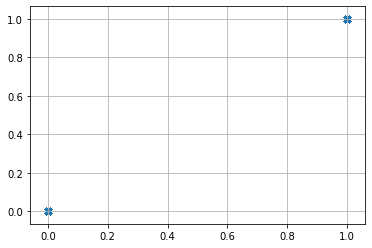

In [71]:
# plot y_pred against y_test to see what we're getting makes more or less sense
plt.scatter(y_test, y_pred, marker='x')
plt.grid()

## Deploy the best performing model

In [65]:
xgb_predictor = xgb_best.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: sagemaker-xgboost-210125-1605-002-aa092f4d


-----------------!

In [85]:
from sagemaker.predictor import csv_serializer

# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [86]:
# split the data into smaller chunks

def predict_chunks(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [87]:
test_preds = np.squeeze(np.round(predict_chunks(X_test.values, xgb_predictor)))

In [90]:
assert len(test_preds) == len(y_test)
assert type(test_preds) == type(y_test)

print(test_preds[0:10])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Model evaluation

This section defines the functions that calculate the metrics used to evaluate the binary classifier on test data and compare its performance to the performance of the benchmark model.

In [91]:
from sklearn.metrics import roc_auc_score

In [92]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(test_preds, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction result and ground truth.  
    Return binary classification metrics.
    :param test_preds: Class prediction from the binary classifier
    :param test_labels: Class labels for test data: ground truth
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """

    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    roc_auc = roc_auc_score(test_labels, test_preds)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('ROC AUC Score:', roc_auc))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [93]:
#evaluate(y_pred, y_test)

predictions      0    1
actuals                
0.0          12872    0
1.0              0  424

Recall:     1.000
Precision:  1.000
Accuracy:   1.000
ROC AUC Score: 1.000



{'TP': 424,
 'FP': 0,
 'FN': 0,
 'TN': 12872,
 'Precision': 1.0,
 'Recall': 1.0,
 'Accuracy': 1.0}

In [94]:
# evaluate against what has been obtained from the deployed endpoint
evaluate(test_preds, y_test)

predictions    0.0  1.0
actuals                
0.0          12872    0
1.0              0  424

Recall:     1.000
Precision:  1.000
Accuracy:   1.000
ROC AUC Score: 1.000



{'TP': 424,
 'FP': 0,
 'FN': 0,
 'TN': 12872,
 'Precision': 1.0,
 'Recall': 1.0,
 'Accuracy': 1.0}

## Evaluate the model against the benchmark

In [ ]:
# tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
y_pred = np.fromstring(Y_pred, sep=',')

In [44]:
TO DO:
    Evaluate with the metrics --> as in the notebook on fraud detection!

SyntaxError: invalid syntax (<ipython-input-44-4560824360b0>, line 1)

# Delete the endpoint

In [ ]:
xgb_predictor.delete_endpoint()

# Clean up

In [ ]:
# delete the data
!rm $data_dir/*

# delete the directory itself
!rmdir $data_dir